# Using n-folds Cross Validation is a stapled piece to any problems for the sake of training. In this post, I have presented the ROC curves and Precision-Recall curves with n-folds Cross-Validation using XGBoost. The ROC one comes from Scikit-Learn documentation and I have customized it for Precision-Recall accordingly.

## Loading Libraries

In [12]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interp
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import itertools
import glmnet
import xgboost as xgb

import seaborn as sns
sns.set_style("ticks")
mpl.rcParams['axes.linewidth'] = 3 
mpl.rcParams['lines.linewidth'] = 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline


# Functions

In [355]:
def _plot_pr_nfolds_xgboost(df_X, Y,
                                     n_folds = 10,
                                     n_estimators = 100,
                                     learning_rate = 0.05,
                                     max_depth = 3,
                                     min_child_weight = 5.0,
                                     gamma = 0.5,
                                     reg_alpha = 0.0,
                                     reg_lambda = 1.0,
                                     subsample = 0.9,
                                     objective = "binary:logistic",
                                     scale_pos_weight = 1.0,
                                     shuffle = True,
                                     random_state = 1367,
                                     saveFigPath = None
                            ):
    """
    a function to plot k-fold cv Precision-Recall (PR) using xgboost
    input parameters:
                     df_X : features : pandas dataframe (numpy array will be built inside the function)
                     Y : targets
                     n_folds : number of cv folds (default = 10)
                     n_estimators = number of trees (default = 100)
                     learning_rate : step size of xgboost (default = 0.05)
                     max_depth : maximum tree depth for xgboost (default = 3)
                     min_child_weight : (default = 5.0)
                     gamma : (default = 0.5)
                     reg_alpha : lasso penalty (L1) (default = 0.0)
                     reg_lambda : ridge penalty (L2) (default = 1.0)
                     subsample : subsample fraction (default = 0.9)
                     objective : objective function for ML (default = "binary:logistic" for classification)
                     scale_pos_weight : (default = 1.0)
                     shuffle : shuffle flag for cv (default = True)
                     random_state : (default = 1367
                     saveFigPath: name of the file for saving the figure as PDF format. (default = None))
    
    """
    
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    from sklearn.model_selection import StratifiedKFold
    from xgboost import XGBClassifier
    from sklearn.preprocessing import scale
    import matplotlib as mpl

    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =7


    # Defining the data + scaling
    if isinstance(df_X, pd.DataFrame):
        X = scale(df_X.values)
    else:
        X = scale(df_X)
        
    y = Y
    n_samples, n_features = X.shape


    # #############################################################################
    # Classification and PR analysis

    # Run classifier with cross-validation and plot PR curves
    cv = StratifiedKFold(n_splits = n_folds , shuffle = shuffle , random_state = random_state)
    classifier = XGBClassifier(learning_rate = learning_rate,
                               n_estimators = n_estimators,
                               max_depth = max_depth,
                               min_child_weight = min_child_weight,
                               gamma = gamma,
                               reg_alpha = reg_alpha,
                               reg_lambda = reg_lambda,
                               subsample = subsample,
                               objective = objective,
                               nthread = 4,
                               scale_pos_weight = 1.,
                               base_score = np.mean(y),
                               seed = random_state,
                               random_state = random_state)
    

    # defining the lists
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(18 , 13))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute PR curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        prs.append(interp(mean_recall, precision, recall))
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))
        i += 1
    
    plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    plt.plot(mean_precision, mean_recall, color='navy',
             label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=4)
    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=30)
    plt.ylabel('Precision',fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend( prop={'size':20} , loc = 0)
    if saveFigPath:
        plt.savefig(F"./{saveFigPath}.pdf" ,bbox_inches='tight')
    plt.show()

 
# --------------------------------------------------------------------------------------

def _plot_roc_nfolds_xgboost(df_X, Y,
                                     n_folds = 10,
                                     n_estimators = 100,
                                     learning_rate = 0.05,
                                     max_depth = 3,
                                     min_child_weight = 5.0,
                                     gamma = 0.5,
                                     reg_alpha = 0.0,
                                     reg_lambda = 1.0,
                                     subsample = 0.9,
                                     objective = "binary:logistic",
                                     scale_pos_weight = 1.0,
                                     shuffle = True,
                                     random_state = 1367,
                                     saveFigPath = None
                            ):
    """
    a function to plot k-fold cv ROC using xgboost
    input parameters:
                     df_X : features : pandas dataframe (numpy array will be built inside the function)
                     Y : targets
                     n_folds : number of cv folds (default = 10)
                     n_estimators = number of trees (default = 100)
                     learning_rate : step size of xgboost (default = 0.05)
                     max_depth : maximum tree depth for xgboost (default = 3)
                     min_child_weight : (default = 5.0)
                     gamma : (default = 0.5)
                     reg_alpha : lasso penalty (L1) (default = 0.0)
                     reg_lambda : ridge penalty (L2) (default = 1.0)
                     subsample : subsample fraction (default = 0.9)
                     objective : objective function for ML (default = "binary:logistic" for classification)
                     scale_pos_weight : (default = 1.0)
                     shuffle : shuffle flag for cv (default = True)
                     random_state : (default = 1367
                     saveFigPath: name of the file for saving the figure as PDF format. (default = None))
    
    """
    
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    from xgboost import XGBClassifier
    from sklearn.preprocessing import scale
    import matplotlib as mpl

    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =7


    # Defining the data + scaling
    if isinstance(df_X, pd.DataFrame):
        X = scale(df_X.values)
    else:
        X = scale(df_X)
        
    y = Y
    n_samples, n_features = X.shape


    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits = n_folds , shuffle = shuffle , random_state = random_state)
    classifier = XGBClassifier(learning_rate = learning_rate,
                               n_estimators = n_estimators,
                               max_depth = max_depth,
                               min_child_weight = min_child_weight,
                               gamma = gamma,
                               reg_alpha = reg_alpha,
                               reg_lambda = reg_lambda,
                               subsample = subsample,
                               objective = objective,
                               nthread = 4,
                               scale_pos_weight = 1.,
                               base_score = np.mean(y),
                               seed = random_state,
                               random_state = random_state)
    

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(18 , 13))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='ROC Fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='navy',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=4)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                     label=r'$\pm$ 1 Standard Deviation')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate' ,  fontweight = "bold" , fontsize=30)
    plt.ylabel('True Positive Rate',fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend( prop={'size':20} , loc = 4)
    if saveFigPath:
        plt.savefig(F"./{saveFigPath}.pdf" ,bbox_inches='tight')
    plt.show()   

# KDD CUP 99 Data

In [356]:
from sklearn.datasets import fetch_kddcup99
data = fetch_kddcup99()
df = pd.DataFrame(data.data)
df.drop([1,2,3], axis = 1, inplace = True)
df = df.astype(np.float32)
# df = df.select_dtypes(exclude=['object'])
y = data.target

In [357]:
df.dtypes

0     float32
4     float32
5     float32
6     float32
7     float32
8     float32
9     float32
10    float32
11    float32
12    float32
13    float32
14    float32
15    float32
16    float32
17    float32
18    float32
19    float32
20    float32
21    float32
22    float32
23    float32
24    float32
25    float32
26    float32
27    float32
28    float32
29    float32
30    float32
31    float32
32    float32
33    float32
34    float32
35    float32
36    float32
37    float32
38    float32
39    float32
40    float32
dtype: object

### Adding noise to features to not have perfect problem

In [358]:
dimensions = df.shape #to get the dimesion of the data
noise = np.random.rand(dimensions[0], dimensions[1])
noisy_df = df + df * noise # to add noise the existing data 

## Checking the targets

In [359]:
pd.Series(y).value_counts()

b'smurf.'              280790
b'neptune.'            107201
b'normal.'              97278
b'back.'                 2203
b'satan.'                1589
b'ipsweep.'              1247
b'portsweep.'            1040
b'warezclient.'          1020
b'teardrop.'              979
b'pod.'                   264
b'nmap.'                  231
b'guess_passwd.'           53
b'buffer_overflow.'        30
b'land.'                   21
b'warezmaster.'            20
b'imap.'                   12
b'rootkit.'                10
b'loadmodule.'              9
b'ftp_write.'               8
b'multihop.'                7
b'phf.'                     4
b'perl.'                    3
b'spy.'                     2
dtype: int64

### Building binary flag for 'back'  or 'normal' class

In [360]:
yy = np.where(((y == b'back.')|(y == b'normal.')), 1, 0)
print(F"Shape: {df.shape}")
print(F"""Prevalence = {yy.sum()/len(yy)* 100:.3f}%""")

Shape: (494021, 38)
Prevalence = 20.137%


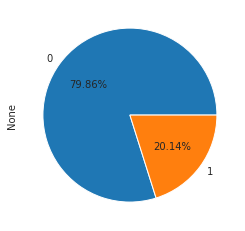

In [361]:
pd.Series(yy).value_counts().plot(kind ="pie", autopct="%1.2f%%")
plt.show()

In [362]:
noisy_df.head()

,0,4,5,6,7,8,9,10,11,12,...,31,32,33,34,35,36,37,38,39,40
0,0.0,210.804036,6844.436574,0.0,0.0,0.0,0.0,0.0,1.888843,0.0,...,12.502868,11.185510,1.111647,0.0,0.182288,0.0,0.0,0.0,0.0,0.0
1,0.0,240.040258,755.161401,0.0,0.0,0.0,0.0,0.0,1.927321,0.0,...,31.836429,36.460213,1.217937,0.0,0.098349,0.0,0.0,0.0,0.0,0.0
2,0.0,359.574976,2614.731730,0.0,0.0,0.0,0.0,0.0,1.506819,0.0,...,48.112809,30.087684,1.936690,0.0,0.054079,0.0,0.0,0.0,0.0,0.0
3,0.0,324.864701,2027.837786,0.0,0.0,0.0,0.0,0.0,1.845100,0.0,...,52.215076,69.985597,1.183668,0.0,0.031935,0.0,0.0,0.0,0.0,0.0
4,0.0,340.145440,2828.912572,0.0,0.0,0.0,0.0,0.0,1.280997,0.0,...,71.912794,93.026926,1.645168,0.0,0.034165,0.0,0.0,0.0,0.0,0.0


# ROC Curve + 10-folds CV with XGBOOST

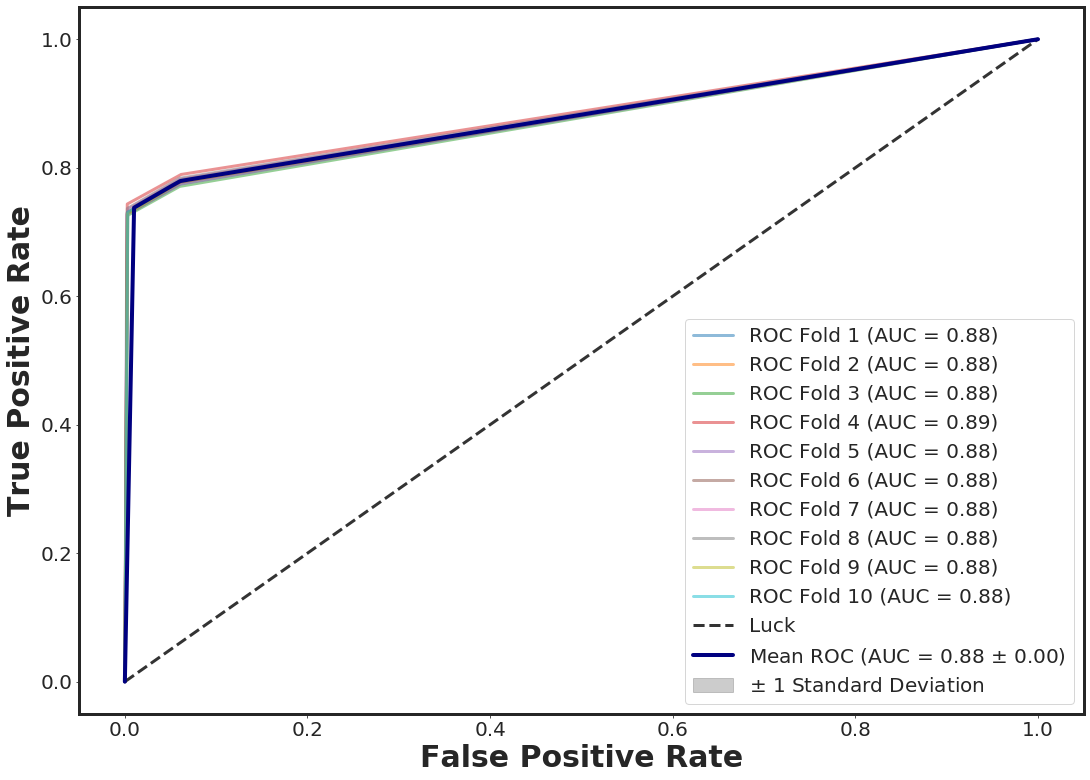

In [363]:
_plot_roc_nfolds_xgboost(noisy_df.loc[:, [ 11, 40]], yy, n_folds = 10, n_estimators = 3)

# Precision Curve + 10-folds CV with XGBOOST

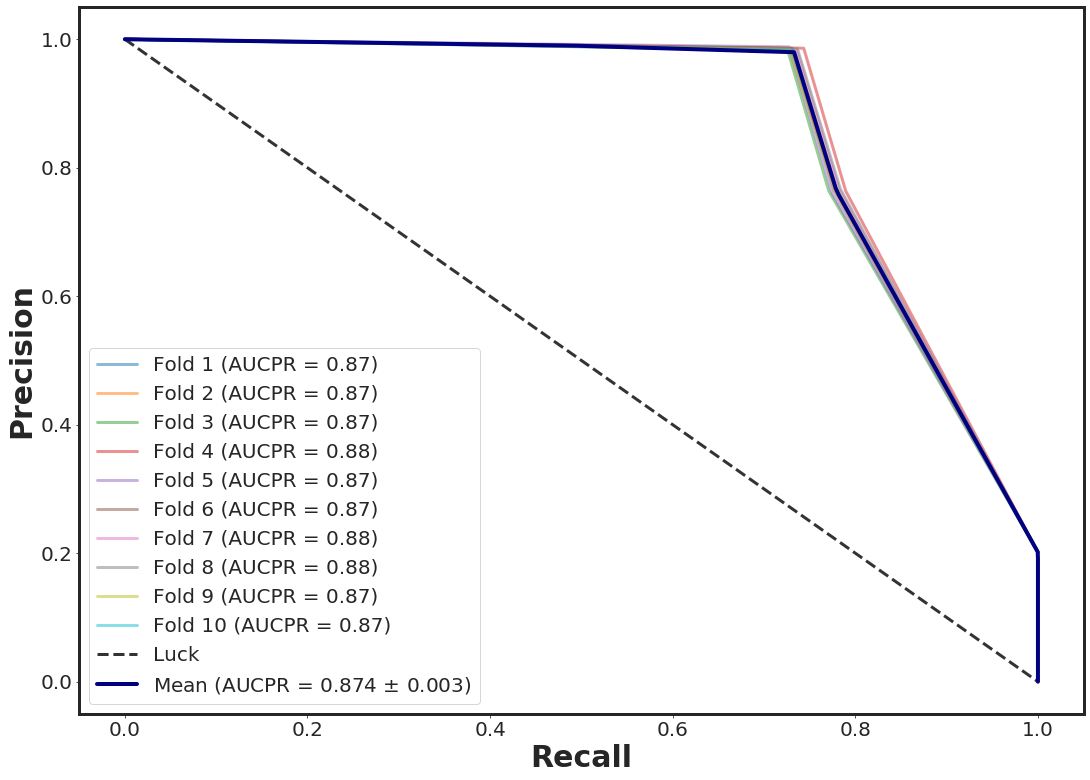

In [364]:
_plot_pr_nfolds_xgboost(noisy_df.loc[:, [11, 40]], yy, n_folds = 10, n_estimators = 3)